In [1]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
from mrcnn import visualize
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [15]:
# Root directory of the project
ROOT_DIR = "D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation"
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR,"logs\\object20241208T1226\\mask_rcnn_object_0024.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")



class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # Background + 7 classes

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

############################################################
#  Dataset
############################################################
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """
        Load a subset of the dataset in COCO format.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val.
        """
        # Add classes (from COCO categories)
        coco_file = os.path.join(dataset_dir, subset, '_annotations.coco.json')
        coco_data = json.load(open(coco_file))
   
        self.add_class("object", 1, "Bedroom")
        self.add_class("object", 2, "Bed_")
        self.add_class("object", 3, "Loft")
        self.add_class("object", 4, "Dresser")
        self.add_class("object", 5, "Wardrobe-sliding")
        self.add_class("object", 6, "Wardrobe-parallel")
        self.add_class("object", 7, "Wardrobe-walk-in")
        
        # Print all added classes
        for cls in self.class_info:
            print(f"Added class: {cls['name']} with ID: {cls['id']}")

        

        # Add images and annotations
        # Get all annotations
        annotations = {}
        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_data['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.join(dataset_dir, subset, image_file_name)
                
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    "object",
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )

    def load_mask(self, image_id):
        """
        Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: A 1D array of class IDs of the instance masks.
        """
        # Fetch image information
        image_info = self.image_info[image_id]
        annotations = image_info.get('annotations', [])  # Get annotations safely
    
        instance_masks = []
        class_ids = []

        # Iterate through annotations
        for annotation in annotations:
            class_id = annotation.get('category_id')  # Safely access category_id
            if not class_id:
                print(f"Warning: Missing category_id for annotation {annotation}")
                continue

            # Create an empty binary mask for the image dimensions
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')

            # Draw polygons for segmentation
            for segmentation in annotation.get('segmentation', []):
                if not segmentation:
                    print(f"Warning: Empty segmentation for annotation {annotation}")
                    continue
                try:
                    mask_draw.polygon(segmentation, fill=1)
                except Exception as e:
                    print(f"Error drawing polygon for annotation {annotation}: {e}")
                    continue

            # Convert the PIL mask to a NumPy array
            bool_array = np.array(mask) > 0
            if bool_array.any():
                instance_masks.append(bool_array)
                class_ids.append(class_id)
            else:
                print(f"Warning: No valid mask for annotation {annotation}")

        # If no valid masks were generated, return empty arrays
        if not instance_masks:
            print(f"Error: No masks generated for image_id {image_id}")
            height, width = image_info['height'], image_info['width']
            return np.zeros((height, width, 0), dtype=bool), np.array([], dtype=np.int32)

        # Stack all instance masks along the third axis
        mask = np.stack(instance_masks, axis=-1)
        class_ids = np.array(class_ids, dtype=np.int32)

        return mask, class_ids



    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)



Added class: BG with ID: 0
Added class: Bedroom with ID: 1
Added class: Bed_ with ID: 2
Added class: Loft with ID: 3
Added class: Dresser with ID: 4
Added class: Wardrobe-sliding with ID: 5
Added class: Wardrobe-parallel with ID: 6
Added class: Wardrobe-walk-in with ID: 7


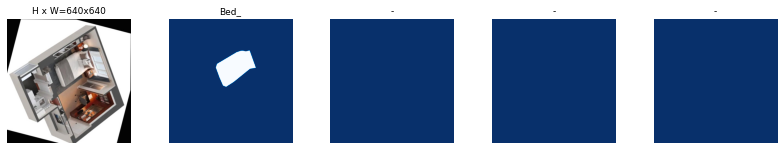

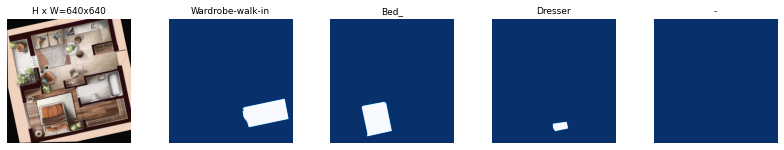

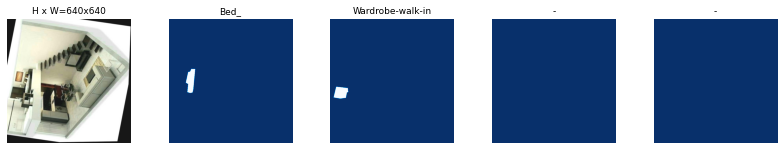

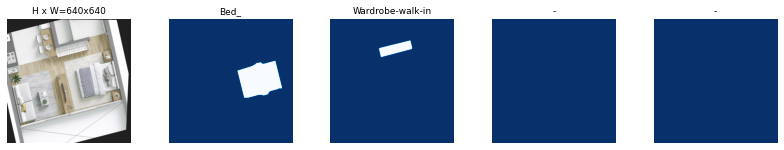

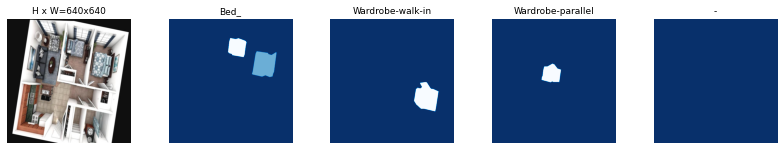

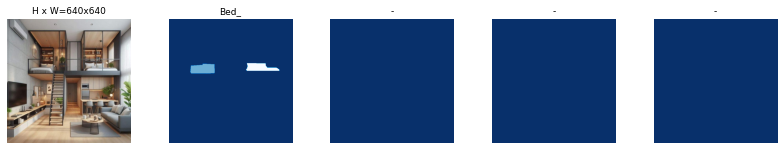

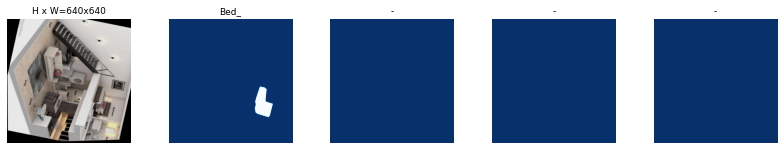

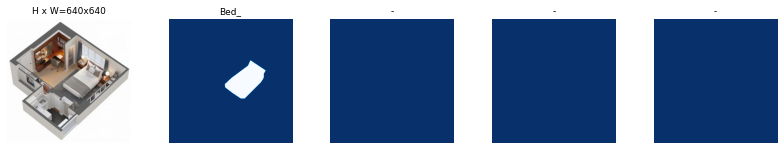

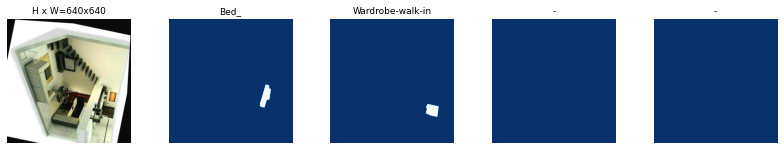

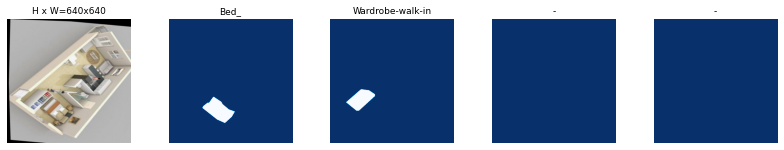

In [16]:
import random
import matplotlib.pyplot as plt

dataset = CustomDataset()
dataset.load_custom("D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\Bedroom annotations", "train")
dataset.prepare()

def visualize_random_annotations(dataset, num_images=10):
    """
    Visualizes random annotations from the dataset.
    Arguments:
    - dataset: The dataset object, expected to have `image_ids` and `load_image_gt` methods.
    - num_images: Number of random images to visualize.
    """
    # Ensure image_ids is a list
    image_ids = list(dataset.image_ids)  # Convert to list if it's not already
    
    # Check if the dataset has enough images
    if len(image_ids) < num_images:
        raise ValueError(f"Dataset contains only {len(image_ids)} images, but {num_images} were requested.")
    
    # Get random image IDs
    selected_image_ids = random.sample(image_ids, num_images)

    for image_id in selected_image_ids:
        image = dataset.load_image(image_id)
        mask, class_ids = dataset.load_mask(image_id)
        
        visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
        
# Example usage
visualize_random_annotations(dataset, num_images=10)

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\Bedroom annotations", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("D:\\Documents\\Python scripts\\BedroomFloorPlanSegmentation\\Bedroom annotations", "valid")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    config.LEARNING_RATE = 0.0001  # Reduce the learning rate
    import tensorflow as tf

    # Convert class weights to a TensorFlow constant
    class_weights_tensor = tf.constant([13.498076923076923, 3.498076923076923, 7.579166666666667, 17.323809523809523,
                                   25.985714285714284, 12.992857142857142, 8.120535714285714])  # Use your computed weights


    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')


    
    
    
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_WEIGHTS_PATH
# Download weights file
if not os.path.exists(weights_path):
    utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model)

Re-starting from epoch 24
Added class: BG with ID: 0
Added class: Bedroom with ID: 1
Added class: Bed_ with ID: 2
Added class: Loft with ID: 3
Added class: Dresser with ID: 4
Added class: Wardrobe-sliding with ID: 5
Added class: Wardrobe-parallel with ID: 6
Added class: Wardrobe-walk-in with ID: 7
Added class: BG with ID: 0
Added class: Bedroom with ID: 1
Added class: Bed_ with ID: 2
Added class: Loft with ID: 3
Added class: Dresser with ID: 4
Added class: Wardrobe-sliding with ID: 5
Added class: Wardrobe-parallel with ID: 6
Added class: Wardrobe-walk-in with ID: 7
Training network heads

Starting at epoch 24. LR=0.0001

Checkpoint Path: D:\Documents\Python scripts\BedroomFloorPlanSegmentation\logs\object20241208T1226\mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                

D:\anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Error: No masks generated for image_id 206


D:\anaconda\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
D:\anaconda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
